<img src="Scoreboard.jpg" width=800 height=1900>

<h1><center> Predicting College Experience Using College Scorecard <center></h1>

<center><b>Zion Joseph, Kelli Webber</b></center>

<h1><center>Introduction</center></h1>
<h4>Placeholder</h4>
<h1><center>Pulling The Data</center></h1>
<h2>Importing libaries</h2>

In [1]:
%%capture
!pip install folium
import folium
import json
import os
import requests
import pandas as pd
import numpy as np
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

<h2>Pulling The Data from CSV</h2>

In [2]:
odata = pd.read_csv("Most-Recent-Cohorts-All-Data-Elements.csv")

odata.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP6_FTNFT_POOLED_SUPP,OMAWDP8_FTNFT_POOLED_SUPP,OMENRYP8_FTNFT_POOLED_SUPP,OMENRAP8_FTNFT_POOLED_SUPP,OMENRUP8_FTNFT_POOLED_SUPP,OMAWDP6_PTNFT_POOLED_SUPP,OMAWDP8_PTNFT_POOLED_SUPP,OMENRYP8_PTNFT_POOLED_SUPP,OMENRAP8_PTNFT_POOLED_SUPP,OMENRUP8_PTNFT_POOLED_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www2.aamu.edu/scripts/netpricecalc/npcalc.htm,...,0.4694,0.5136,0.0034,0.1429,0.3401,0.3333,0.3333,0,0,0.6667
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,uab.studentaidcalculator.com/survey.aspx,...,0.6117,0.624,0.0075,0.2166,0.1519,0.3642,0.4,0.0434,0.2755,0.2811
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,www2.amridgeuniversity.edu:9091/,...,0.5503,0.5562,0.0059,0.4379,0,0.4429,0.4714,0.0429,0.4857,0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.5456,0.5651,0.0123,0.2841,0.1385,0.3378,0.3547,0.0236,0.4257,0.1959
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.4105,0.429,0.0062,0.216,0.3488,0.2931,0.3103,0.0345,0.3966,0.2586


<h2>Tidying of Columns</h2>

In [3]:
# Choose specific columns to display
data = odata[['INSTNM', 'CITY', 'STABBR', 'LONGITUDE', 'LATITUDE', 'MENONLY', 'WOMENONLY','ADM_RATE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'UGDS', 'AGE_ENTRY']]
# made a sample of the orignal data set
data.head()

,INSTNM,CITY,STABBR,LONGITUDE,LATITUDE,MENONLY,WOMENONLY,ADM_RATE,TUITIONFEE_IN,TUITIONFEE_OUT,UGDS
0,Alabama A & M University,Normal,AL,-86.568502,34.783368,0.0,0.0,0.8738,9366.0,17496.0,4616.0
1,University of Alabama at Birmingham,Birmingham,AL,-86.799345,33.505697,0.0,0.0,0.5814,8040.0,18368.0,12047.0
2,Amridge University,Montgomery,AL,-86.174010,32.362609,0.0,0.0,NaN,7180.0,7180.0,293.0
3,University of Alabama in Huntsville,Huntsville,AL,-86.640449,34.724557,0.0,0.0,0.7628,9842.0,20612.0,6346.0
4,Alabama State University,Montgomery,AL,-86.295677,32.364317,0.0,0.0,0.4590,9220.0,16156.0,4704.0


Condensed the two columns MENONLY and WOMENONLY to one column named SEX

In [4]:
#TIDY
gender = []
for index, row in data.iterrows():
    if np.isnan(row ['WOMENONLY']) | np.isnan(row ['MENONLY']):
        gender.append(float('nan'))
    elif (row ['WOMENONLY'] == 1.) & (row ['MENONLY'] == 0.):
        gender.append('WOMENONLY')
    elif (row ['MENONLY'] == 1.) & (row ['WOMENONLY'] == 0.):
        gender.append('MENONLY')
    else:# (row ['WOMENONLY']) == 0. & (row ['MENONLY']) == 0.:
        gender.append('CO-ED')
data = data.drop(columns=['WOMENONLY', 'MENONLY'])
data['GENDER']= gender


data = data[['INSTNM', 'CITY', 'STABBR', 'LONGITUDE', 'LATITUDE', 'GENDER', 'ADM_RATE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'UGDS', 'AGE_ENTRY']]
data.head()

,INSTNM,CITY,STABBR,LONGITUDE,LATITUDE,GENDER,ADM_RATE,TUITIONFEE_IN,TUITIONFEE_OUT,UGDS
0,Alabama A & M University,Normal,AL,-86.568502,34.783368,CO-ED,0.8738,9366.0,17496.0,4616.0
1,University of Alabama at Birmingham,Birmingham,AL,-86.799345,33.505697,CO-ED,0.5814,8040.0,18368.0,12047.0
2,Amridge University,Montgomery,AL,-86.174010,32.362609,CO-ED,NaN,7180.0,7180.0,293.0
3,University of Alabama in Huntsville,Huntsville,AL,-86.640449,34.724557,CO-ED,0.7628,9842.0,20612.0,6346.0
4,Alabama State University,Montgomery,AL,-86.295677,32.364317,CO-ED,0.4590,9220.0,16156.0,4704.0


<h2>Visualization of college locations</h2>

In [5]:
map_osm = folium.Map(location=[39.29, -100.61], zoom_start=4)
sampdata = data.sample(n = 1000)
noNaN = sampdata.dropna(subset = ['LATITUDE', 'LONGITUDE'])

for index, row in noNaN.iterrows():   
    color= 'black'
    folium.Circle(
    tooltip=row['INSTNM'],
    radius=40000,
    location=[row['LATITUDE'], row['LONGITUDE']],
    color=color,
    fill=True,
).add_to(map_osm)
    
map_osm

<h2><center>Exploratory Data analysis</center></h2>

In [6]:
admissions = data.dropna(subset = ['INSTNM', 'ADM_RATE'])
admissions= admissions.groupby(['STABBR'], as_index=False)['ADM_RATE', 'UGDS'].mean()
admissions.head()

,STABBR,ADM_RATE,UGDS
0,AK,0.650850,4641.000000
1,AL,0.638853,4839.566667
2,AR,0.697232,4154.105263
3,AZ,0.676111,10085.736842
4,CA,0.612773,5656.950704


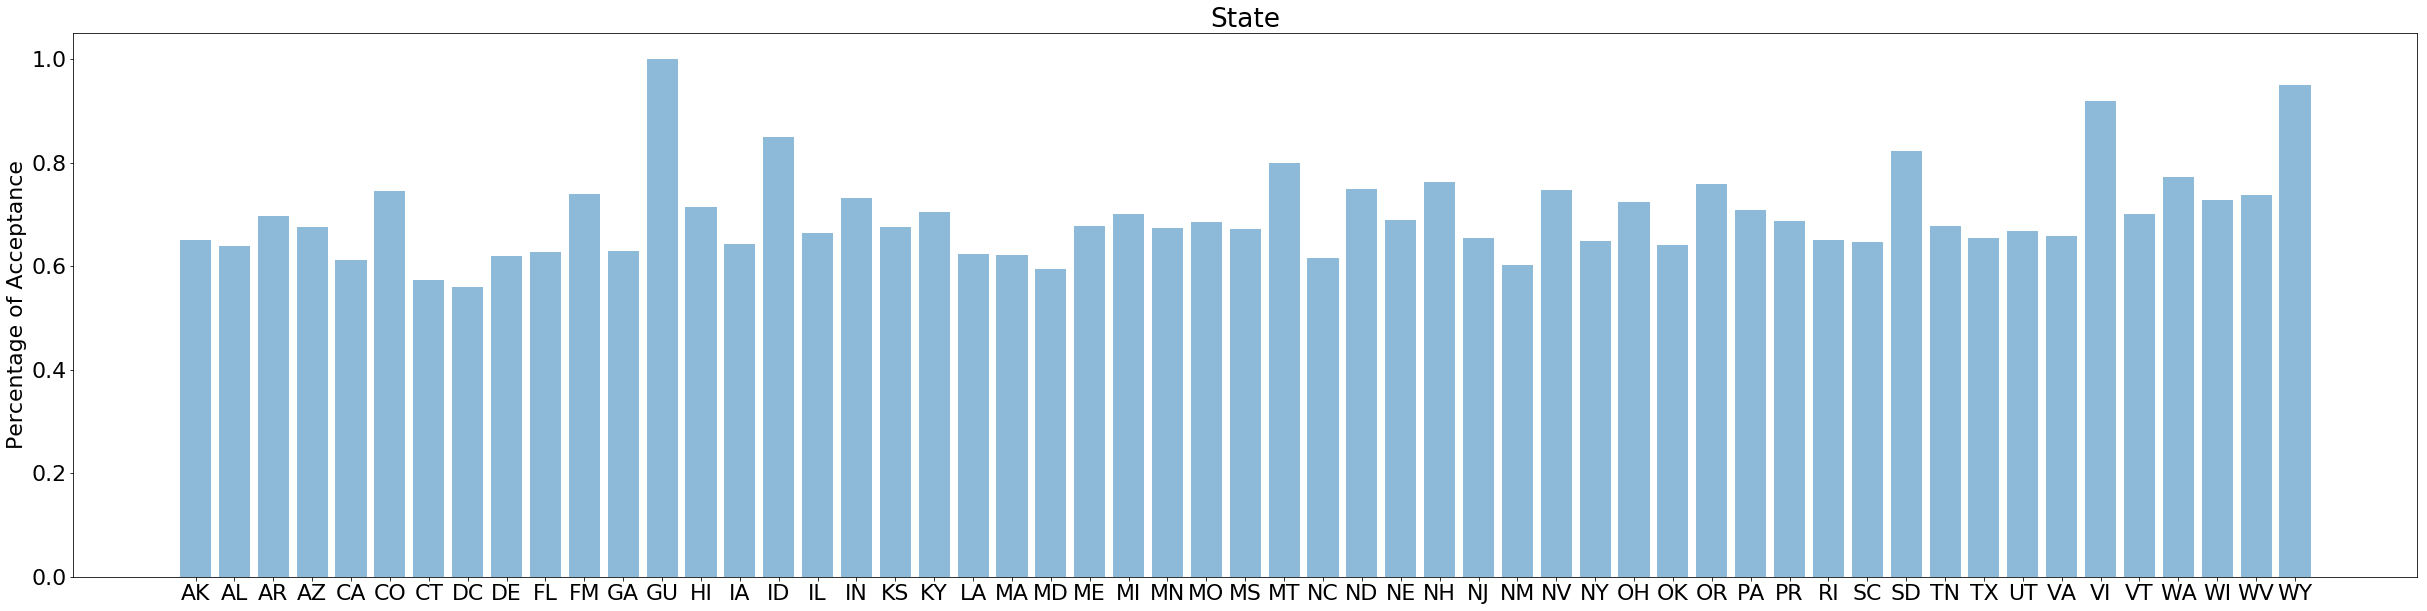

In [7]:
plt.figure(num=None, figsize=(42, 10))
x = admissions['STABBR']
y = admissions['ADM_RATE']
plt.rcParams.update({'font.size': 22})
plt.bar(x, y, align='center', alpha=0.5)
plt.ylabel('Percentage of Acceptance')
plt.title('State')
 
plt.show()

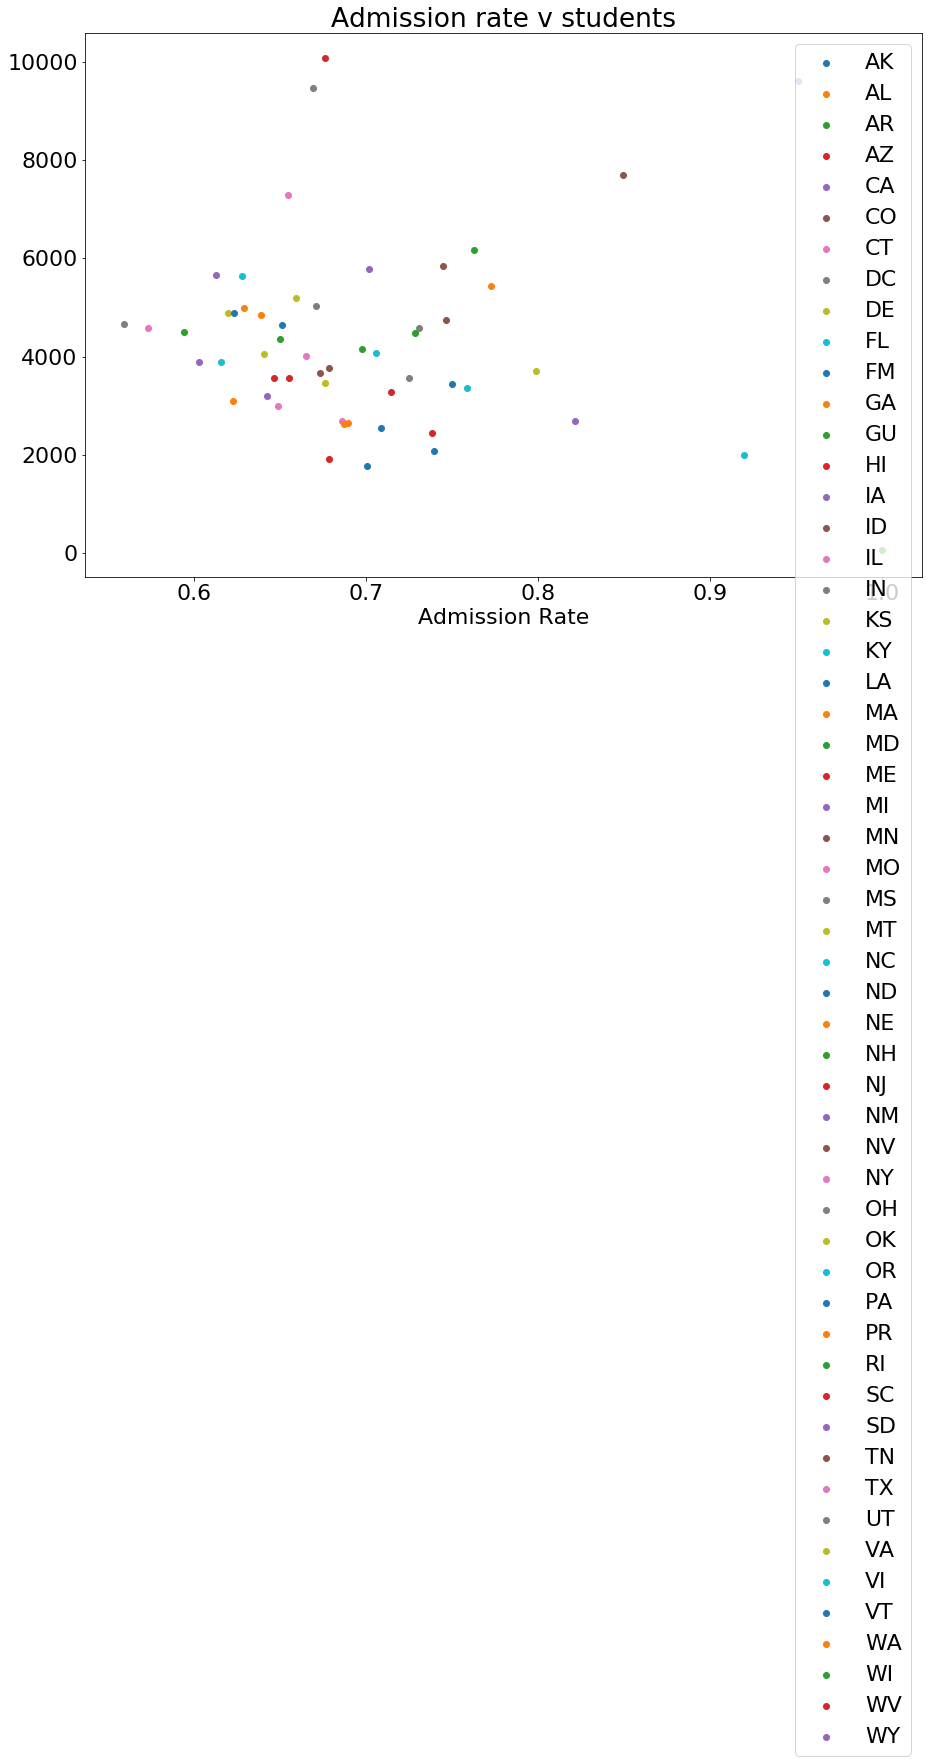

In [8]:
z = admissions['UGDS']
fig = plt.figure(figsize=(15,10))  
ax = fig.add_subplot(1,1,1)

States = []
for ele, d in admissions.groupby('STABBR'):
    States.append(str(ele)) 

for b, d in admissions.groupby('STABBR'):
    plt.scatter(d['ADM_RATE'], d['UGDS'], label= str(admissions['STABBR']))
ax.legend(States)
# plot.set_yticks(numpy.arange(0,  238070000, 5000000))
ax.set_title("Admission rate v students")
ax.set_xlabel("Admission Rate")

plt.show()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

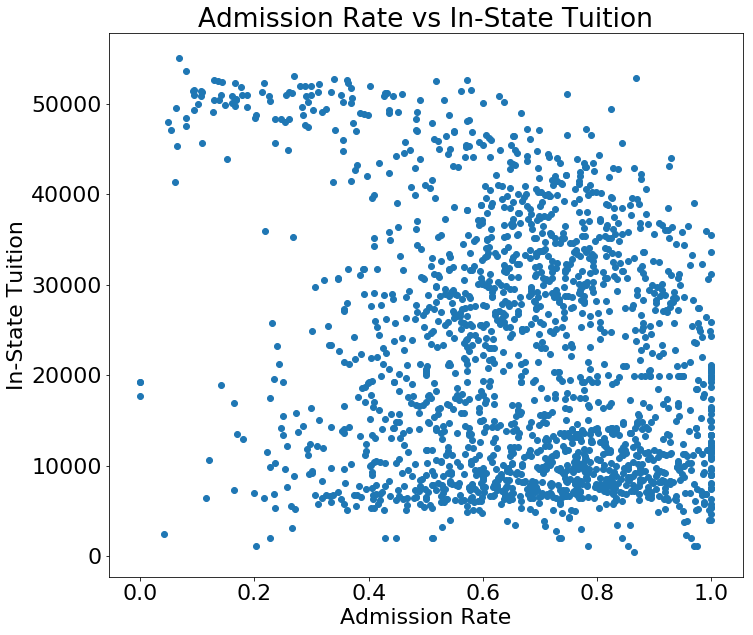

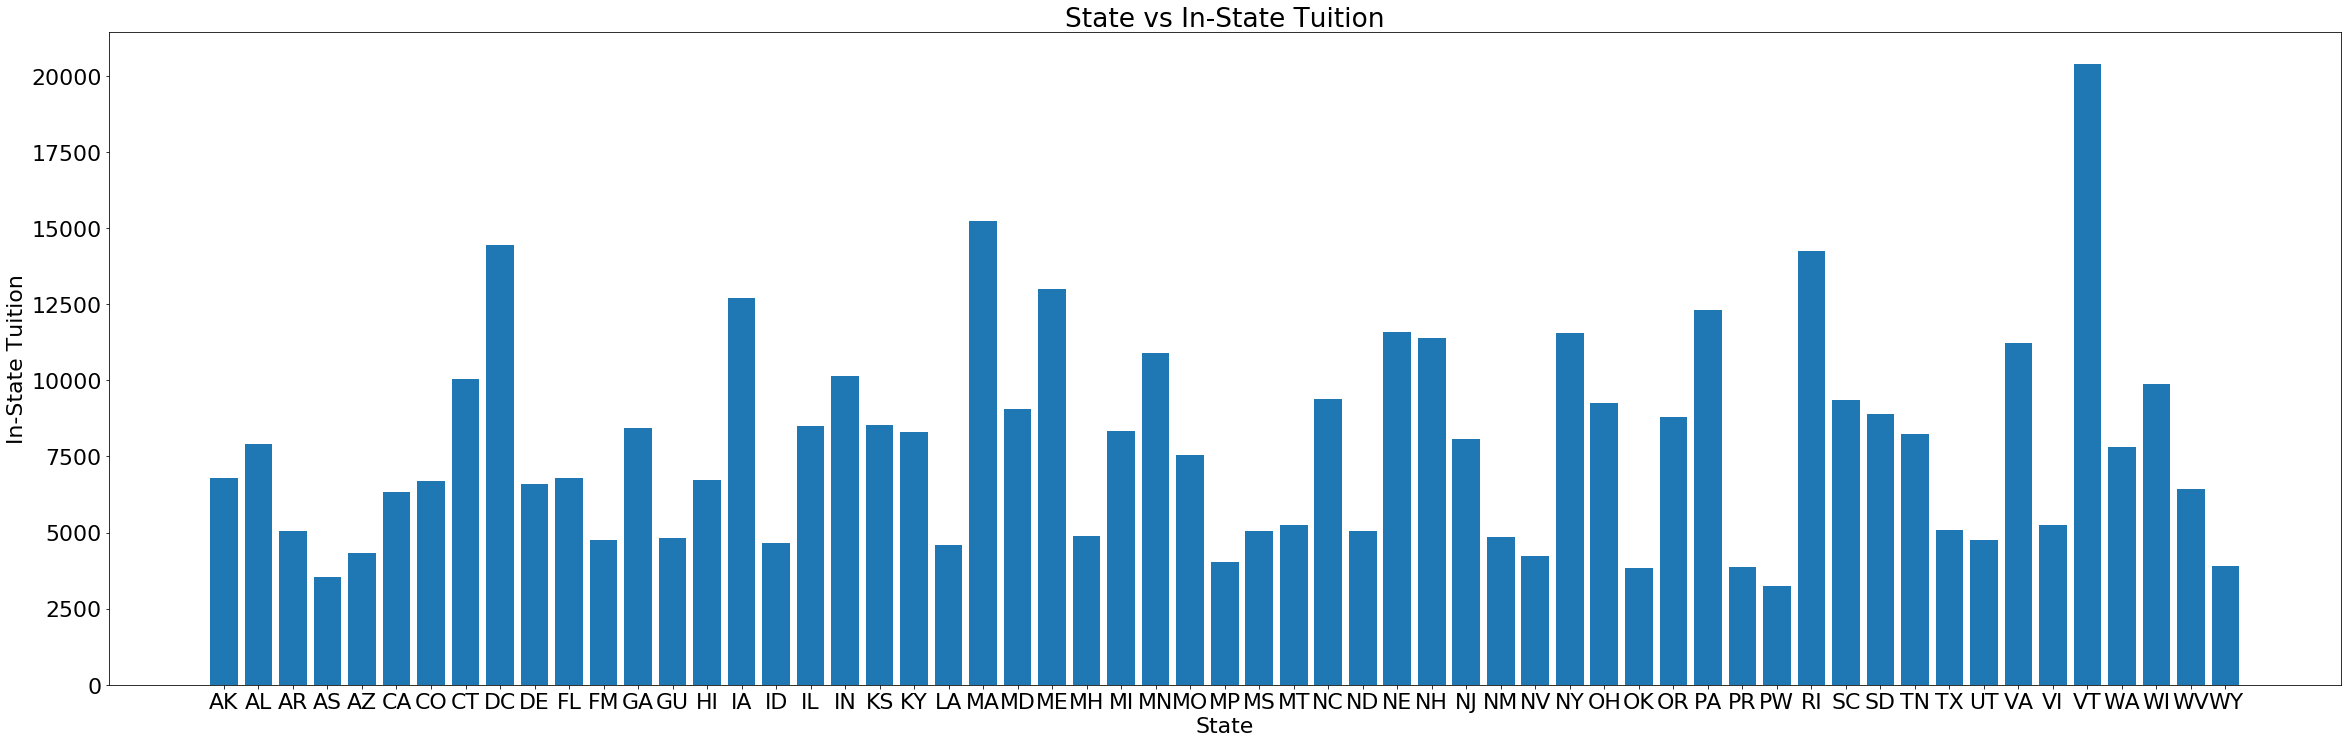

In [12]:
fig = plt.figure(figsize=(25,10))
plot = fig.add_subplot(121)
plot.scatter(data['ADM_RATE'],data['TUITIONFEE_IN'])
plot.set_title('Admission Rate vs In-State Tuition')
plot.set_xlabel('Admission Rate')
plot.set_ylabel('In-State Tuition')
plt


fig = plt.figure(figsize=(40,12))
plot = fig.add_subplot(1,1,1)

State_Abbr = []
for ele, df in data.groupby('STABBR'):   
    State_Abbr.append(str(ele))

tuition_averages = []
for b, df in data.groupby('STABBR'):   
    t = df['TUITIONFEE_IN'].sum()
    c = len(df['TUITIONFEE_IN'])
    tuition_averages.append(t/c)

x_pos = [i for i, _ in enumerate(State_Abbr)]
plt.bar(State_Abbr, tuition_averages)
plot.set_title('State vs In-State Tuition')
plot.set_xlabel('State')
plot.set_ylabel('In-State Tuition')
plt